### Deep Q Network for navigating through a grid world with different goal locations with fixed obstacles
#### Reward system 2: As per the paper - "Autonomous Navigation of an AMR using Deep Reinforcement Learning in a Warehouse Environment" (Episode terminates if the bot hits the bounds or obstacles)

##### Final model name: 

##### This model has a step function where env.done is only true iff the bot reaches the goal and not when it hits the bounds or obstacles

In [ ]:
import random
import pickle

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
# print gpu info
print(tf.config.list_physical_devices('GPU'))

In [ ]:
# Create a neural network model
def create_model(input_shape, num_actions):
    model = Sequential([
        Input(shape=input_shape),
        Dense(16, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_actions, activation='linear')
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

In [ ]:
# Create a class for the environment
class Env():
    def __init__(self, grid_size=11, max_steps=500):
        self.grid_size = grid_size
        self.max_steps = max_steps
        
        self.obstacles = np.array([[2,0],[2,1],[2,2],[2,3],[2,4],[6,6],[6,7],[6,8],[6,9],[6,10]])
        # self.rewards = np.zeros((grid_size, grid_size))
        self.reset()
        self.reset_goal()

    def check(self, test, array):
        return any(np.array_equal(x, test) for x in array)

    def reset(self):
        self.pos = np.random.randint(0, self.grid_size, size=2)
        while self.check(self.pos, self.obstacles):
            self.pos = np.random.randint(0, self.grid_size, size=2)
        self.steps = 0
        self.done = False
        return self.pos
    
    def reset_goal(self):
        self.goal = np.random.randint(0, self.grid_size, size=2)
        while self.check(self.goal, self.obstacles) or np.array_equal(self.pos, self.goal):
            self.goal = np.random.randint(0, self.grid_size, size=2)
        print('Goal:', self.goal)
        # for i in range(self.grid_size):
        #     for j in range(self.grid_size):
        #         self.rewards[i, j] = -self.euclidean_distance_from_goal(np.array([i, j]))
        # self.rewards[self.goal[0], self.goal[1]] = 100
        return self.goal
    
    # def step(self, action):
    #     self.steps += 1
    #     if action == 0 and self.pos[0] < self.grid_size - 1: # right
    #         self.pos[0] += 1
    #     elif action == 1 and self.pos[0] > 0: # left
    #         self.pos[0] -= 1
    #     elif action == 2 and self.pos[1] > 0: # down
    #         self.pos[1] -= 1
    #     elif action == 3 and self.pos[1] < self.grid_size - 1: # up
    #         self.pos[1] += 1
    #     else:
    #         pass
    #         # raise ValueError('Invalid action')
    #     if np.array_equal(self.pos, self.goal):
    #         self.done = True
    #         reward = 0
    #         # reward = 100
    #     elif self.steps >= self.max_steps:
    #         self.done = True
    #         reward = self.rewards[self.pos[0], self.pos[1]]
    #     else:
    #         reward = self.rewards[self.pos[0], self.pos[1]]
    #     return self.pos, reward, self.done

    def step(self, action): # As per the paper
        self.steps += 1
        prev_pos = self.pos.copy()
        if action == 0 and self.pos[0] < self.grid_size - 1 and not (self.pos + np.array([1, 0])) in self.obstacles: # right
            self.pos[0] += 1
        elif action == 1 and self.pos[0] > 0 and not (self.pos - np.array([1, 0])) in self.obstacles: # left
            self.pos[0] -= 1
        elif action == 2 and self.pos[1] > 0 and not (self.pos - np.array([0, 1])) in self.obstacles: # down
            self.pos[1] -= 1
        elif action == 3 and self.pos[1] < self.grid_size - 1 and not (self.pos + np.array([0, 1])) in self.obstacles: # up
            self.pos[1] += 1
        else:
            reward = -150
            self.done = False
            return self.pos, reward, self.done, True # TODO: The episode is not terminated.
        if np.array_equal(self.pos, self.goal):
            self.done = True
            reward = 500
        elif self.steps >= self.max_steps:
            self.done = True
            reward = 0
        else:
            if self.euclidean_distance_from_goal(self.pos) < self.euclidean_distance_from_goal(prev_pos):
                reward = 10
            else:
                reward = -10
        return self.pos, reward, self.done, False
        

    def euclidean_distance_from_goal(self, pos):
        dist = np.sqrt(np.sum((pos - self.goal) ** 2))
        return dist
        
        

In [ ]:
# Create an agent class
class Agent():
    def __init__(self, env, model, target_model):
        self.env = env
        self.model = model
        self.target_model = target_model
        self.target_model.set_weights(self.model.get_weights())
        self.gamma = 0.7
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.001
        self.batch_size = 64
        self.memory = deque(maxlen=1000)
        

    def add_to_memory(self, state, goal, action, reward, next_state, done):
        self.memory.append((state, goal, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 4)
        else:
            # Pre-process the input
            inputt = np.concatenate((state, self.env.goal))
            inputt = tf.convert_to_tensor(inputt)
            inputt = tf.expand_dims(inputt, 0)

            return np.argmax(self.model.predict(inputt, verbose=0)[0]) # TODO: check the predict output

    def predict(self, inputt):

        return np.argmax(self.model.predict(inputt, verbose=0)[0])

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, goal, action, reward, next_state, done in batch:
            
            target = reward

            if not done:
                # Pre-process the next state input
                input_next = np.concatenate((next_state, goal))
                input_next = tf.convert_to_tensor(input_next)
                input_next = tf.expand_dims(input_next, 0)

                target += self.gamma * np.amax(self.target_model.predict(input_next, verbose=0)[0])

            # Pre-process the current state input
            inputt = np.concatenate((state, goal))
            inputt = tf.convert_to_tensor(inputt)
            inputt = tf.expand_dims(inputt, 0)

            cur_q_value = self.model.predict(inputt, verbose=0) # Q-value of current state
            cur_q_value[0][action] = target # TODO: check the predict output
            
            self.model.fit(inputt, cur_q_value, epochs=1, verbose=0)
            

In [ ]:
# Initialize the agent

try:
    model = tf.keras.models.load_model('doublenet_dqn_diff_start_diff_goal_obst_eleven.h5')
    print("Loaded model from disk")
    agent = Agent(Env(), model=model, target_model=model)
except:
    print("Creating new model")
    agent = Agent(Env(), model=create_model(input_shape=(4,), num_actions=4), target_model=create_model(input_shape=(4,), num_actions=4))


In [ ]:
filee = open('memory.bin', 'rb')
agent.memory = pickle.load(filee)
filee.close()

In [ ]:
# Train the agent

num_episodes = 250
# num_episodes = 5
reward_lst = []
start_ep = 1500

file = open('rewards.txt', 'a')

for episode in range(start_ep, start_ep+num_episodes):
    state_lst = [] # DEBUG
    ep_reward = 0 # DEBUG
    state = agent.env.reset()
    for step in range(agent.env.max_steps):
        state_lst.append(state.copy()) # DEBUG
        # print('State:', state) # DEBUG
        # print('state_lst:', state_lst) # DEBUG
        action = agent.act(state)
        # print('Action:', action) # DEBUG
        next_state, reward, done, terminate = agent.env.step(action)
        ep_reward += reward # DEBUG
        # print(f"next_state: {next_state}, reward: {reward}, done: {done}") # DEBUG
        # next_state = np.reshape(next_state, [1, 2])
        agent.add_to_memory(state, agent.env.goal, action, reward, next_state, done)
        state = next_state
        if done:
            if np.array_equal(agent.env.goal, agent.env.pos): # Reached the goal
                agent.env.reset_goal()
        elif (agent.env.steps >= agent.env.max_steps) or terminate:
            print('Episode: {}/{}, steps: {}, e: {:.2}'.format(episode, num_episodes, step+1, agent.epsilon))
            print('State list:', state_lst) # DEBUG
            break
    if len(agent.memory) > agent.batch_size:
        agent.replay()
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = (1 - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode) + agent.epsilon_min
    if episode % 5 == 0:
        agent.model.save('doublenet_dqn_diff_start_diff_goal_obst_eleven.h5')    
    agent.target_model.set_weights(agent.model.get_weights())

    reward_lst.append(ep_reward) # DEBUG
    file.write(f"{episode},{ep_reward}\n") # DEBUG
    file.flush() # DEBUG

agent.model.save('doublenet_dqn_diff_start_diff_goal_obst_eleven.h5')

print('Average reward:', np.mean(reward_lst))

In [ ]:
filee = open('memory.bin', 'wb')
pickle.dump(agent.memory, filee)
filee.close()

In [ ]:
# Test the agent
success = 0
crash = 0
no_tests = 500
for i in range(no_tests):
    state = agent.env.reset()
    goal = agent.env.reset_goal()
    print('Goal:', goal)
    for step in range(30):
        print('State:', state)
        inputt = np.concatenate((state, goal))
        inputt = tf.convert_to_tensor(inputt)
        inputt = tf.expand_dims(inputt, 0)
        action = agent.predict(inputt)
        next_state, reward, done, terminate = agent.env.step(action)
        state = next_state
        if done:
            print('State:', state)
            print('Steps: ', step+1)
            if np.array_equal(agent.env.goal, agent.env.pos):
                print('Reached the goal!')
                success += 1
            break
        elif terminate:
            print('State:', state)
            print('Steps: ', step+1)
            print('Terminated!')
            crash += 1
            break

print('Success rate:', success/no_tests)
print('Crash rate:', crash/no_tests)
print('Oscillate rate:', (no_tests - success - crash)/no_tests)

In [ ]:
# testing for custom goal and random start point:
state = agent.env.reset()
goal = agent.env.reset_goal()
# print('Goal:', goal)

for step in range(30):
    print('State:', state)
    inputt = np.concatenate((state, goal))
    inputt = tf.convert_to_tensor(inputt)
    inputt = tf.expand_dims(inputt, 0)
    action = agent.predict(inputt)
    next_state, reward, done, terminate = agent.env.step(action)
    state = next_state
    if done:
        print('State:', state)
        print('Steps: ', step+1)
        if np.array_equal(agent.env.goal, agent.env.pos):
            print('Reached the goal!')
        break
    if terminate:
        print('Steps: ', step+1)
        print("Crashed into a wall")
        break


In [ ]:
import matplotlib.pyplot as plt
plt.plot(reward_lst)
plt.xlabel("Episode")
plt.ylabel("Reward")
# PLot mean line for 10 episodes
mean_lst = []
for i in range(len(reward_lst)):
    if i < 10:
        mean_lst.append(np.mean(reward_lst[:i+1]))
    else:
        mean_lst.append(np.mean(reward_lst[i-10:i+1]))
plt.plot(mean_lst)
plt.show()


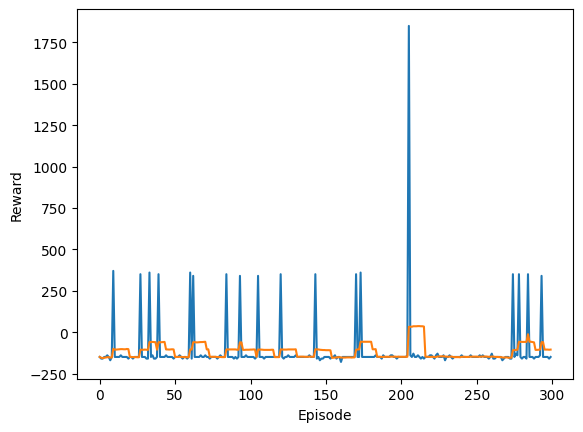

#### Test Results:

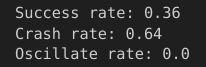

##### Hyperparameters:

- Learning rate: 0.001
- Discount factor (gamma): 0.7
- Epsilon: 1.0
- Epsilon decay: 0.01
- Epsilon min: 0.01
- Batch size: 64
- Memory size: 1000
- Target update frequency: 1 (every 1 episode)
- Number of episodes: 1200
- Number of steps per episode: 500
- Number of hidden layers: 3
- Number of neurons in hidden layers: 16, 32, 32
- Activation function: ReLU
- Optimizer: Adam
- Loss function: MSE
